In [6]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

### load MNIST dataset

In [7]:
from scipy.io import loadmat
train_mnist = loadmat('mnist_train.mat')

In [8]:
data = train_mnist['train_X']
data.shape

(60000, 784)

In [9]:
labels = train_mnist['train_labels']
labels.shape

(60000, 1)

#### initialize pytorch dataloader

In [10]:
class MyMNISTDataset(object):
    def __init__(self, x):
        self.x = x
    
    def __getitem__(self, idx):
        return self.x[idx]
    
    def __len__(self):
        return self.x.shape[0]
    

from torch.utils.data import DataLoader


dataset = MyMNISTDataset(data)
dataloader = DataLoader(dataset, batch_size=2000, shuffle=False)

### label-added VAE and multi-classifier model and training configuration

In [62]:
batch_size = 250 
epochs = 10 
rnd_seed = 5
log_interval = 10
num_clusters = 10

input_label_dim, h1_dim, h2_dim, h3_dim, embed_dim, output_dim  = 784 + num_cluster, 500, 500, 2000, 10, 784

input_dim, g_dim = 784, 2000

### define discriminative model p(y|x)

In [ ]:
class multiclassifier(nn.Module):
    def __init__(self):
        super(multiclassifier, self).__init__()
        # hidden layer 
        self.fc1 = nn.Linear(input_dim, g_dim)
        self.fc2 = nn.Linear(g_dim, num_clusters)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        

### define VAE model 

In [26]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # encoder phase
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, h3_dim)
        self.fc41 = nn.Linear(h3_dim, embed_dim)
        self.fc42 = nn.Linear(h3_dim, embed_dim)
        # decoder phase
        self.fc5 = nn.Linear(embed_dim, h3_dim)
        self.fc6 = nn.Linear(h3_dim, h2_dim)
        self.fc7 = nn.Linear(h2_dim, h1_dim)
        self.fc8 = nn.Linear(h1_dim, input_dim)
        # define activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h3 = self.relu(self.fc3(self.relu(self.fc2(self.relu(self.fc1(x))))))
        return self.fc41(h3), self.fc42(h3)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        recon = self.sigmoid(self.fc8(self.relu(self.fc7(self.relu(self.fc6(self.relu(self.fc5(z))))))))
        return recon

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

### define ELOB loss function

In [58]:
reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

### training the model

In [28]:
model = VAE()

In [39]:
from torch.autograd import Variable

In [60]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dtype = torch.FloatTensor

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        data = Variable(data.float())
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))

### finnally !!!

In [63]:
for epoch in range(1, epochs + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 200.859844
Train Epoch: 1 [20000/60000 (33%)]	Loss: 193.738234
Train Epoch: 1 [40000/60000 (67%)]	Loss: 184.248172
====> Epoch: 1 Average loss: 172.6084
Train Epoch: 2 [0/60000 (0%)]	Loss: 184.882187
Train Epoch: 2 [20000/60000 (33%)]	Loss: 190.426578
Train Epoch: 2 [40000/60000 (67%)]	Loss: 179.935188
====> Epoch: 2 Average loss: 171.6789
Train Epoch: 3 [0/60000 (0%)]	Loss: 183.365953
Train Epoch: 3 [20000/60000 (33%)]	Loss: 195.861500
Train Epoch: 3 [40000/60000 (67%)]	Loss: 181.942719
====> Epoch: 3 Average loss: 169.8551
Train Epoch: 4 [0/60000 (0%)]	Loss: 182.318984
Train Epoch: 4 [20000/60000 (33%)]	Loss: 188.015125
Train Epoch: 4 [40000/60000 (67%)]	Loss: 179.552687
====> Epoch: 4 Average loss: 169.0107
Train Epoch: 5 [0/60000 (0%)]	Loss: 187.827516
Train Epoch: 5 [20000/60000 (33%)]	Loss: 197.179297
Train Epoch: 5 [40000/60000 (67%)]	Loss: 179.025781
====> Epoch: 5 Average loss: 169.8673
Train Epoch: 6 [0/60000 (0%)]	Loss: 202.657922
Train Ep

### check out the trained model: generate a realistic example from 10-dim Guassian points

In [11]:
eps = torch.FloatTensor(np.zeros(10)).normal_()

In [13]:
one_example = model.decode(Variable(eps))

NameError: name 'model' is not defined

In [14]:
one_example = one_example.data.numpy()

NameError: name 'one_example' is not defined

In [90]:
one_example = np.reshape(one_example, (28, 28))

In [91]:
one_example.shape

(28, 28)

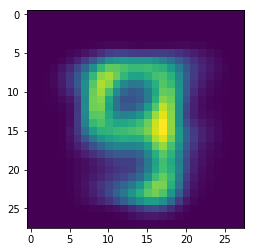

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(one_example)